In [1]:
from time import time
import pandas as pd
import numpy as np
from PIL import Image
from keras import optimizers
import keras.layers.advanced_activations
import scipy
import random
import matplotlib.pyplot as plt  
from scipy.stats import norm  
import keras
from keras.models import Sequential
from keras.initializers import VarianceScaling,RandomNormal
from keras.layers import Input, Dense, Dropout, Conv2D, MaxPooling2D, concatenate
from keras.layers import UpSampling2D, Reshape, Lambda, Flatten, Activation,Concatenate,Add
from keras.models import Model  
from keras.optimizers import SGD, Adadelta, Adagrad,Adam
from keras import backend as K  
from keras import objectives  
from keras.utils.vis_utils import plot_model  
from keras.utils import np_utils, generic_utils
import sys 
import tensorflow as tf
from keras.callbacks import TensorBoard, ModelCheckpoint
from keras.layers import BatchNormalization
from keras.layers.normalization import BatchNormalization
import matplotlib.pyplot as plt
import os
#os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import sklearn
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import NullFormatter
%matplotlib inline
from sklearn import manifold, datasets,cluster
from sklearn.utils import check_random_state
from sklearn import metrics

Using TensorFlow backend.


In [2]:
train_label = np.load("seg_train.npy").reshape([-1,256,256,1])
test_label = np.load("seg_val.npy").reshape([-1,256,256,1])
train_data = np.load("img_train.npy").reshape([-1,256,256,1])
test_data = np.load("img_val.npy").reshape([-1,256,256,1])

In [3]:
train_data = np.log(train_data + 1.0)
test_data = np.log(test_data + 1.0)
train_data = train_data/train_data.max()
test_data = test_data/test_data.max()

In [4]:
train_label = np_utils.to_categorical(train_label, 2)
test_label = np_utils.to_categorical(test_label, 2)

In [5]:
img_rows, img_cols = 256, 256
img_channels = 1

batch_size =50
latent_dim = 256
nb_epoch = 50
intermediate_dim =256
original_dim = img_rows*img_cols
LRelu = 'relu'

#USE = 'autoencoder'
#USE = 'vae'
#encoder:
input_img = Input(shape=(img_rows, img_cols,img_channels))
conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(input_img)
conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
drop4 = Dropout(0.5)(conv4)
pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
drop5 = Dropout(0.5)(conv5)

up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
merge6 = Concatenate()([drop4,up6])
conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
merge7 = Concatenate()([conv3,up7])
conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
merge8 =Concatenate()([conv2,up8])
conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
merge9 = Concatenate()([conv1,up9])
conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
conv10 = Conv2D(2, 1, activation = 'softmax')(conv9)

unet = Model(input = input_img, output = conv10)





#decoded = Conv2D(2, (3, 3), activation='softmax', padding='same')(upsample_10)
#decoded = Flatten()(decoded)
#decoded = Dense(256*256,activation='softmax')(decoded)


EarlyStopping = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=7, verbose=0, mode='auto')
checkpoint = ModelCheckpoint('model_keras_unet.h5',monitor ='val_loss',verbose = 1,save_best_only = True)

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true[:,:,:,1]) 
    y_pred_f = K.flatten(y_pred[:,:,:,1]) 
    intersection = K.sum(y_true_f * y_pred_f) 
    return (2. * intersection + 1e-6) / (K.sum(K.square(y_true_f)) + K.sum(K.square(y_pred_f)) + 1e-6)
def dice_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

#def ae_loss(x, decoded):  
#    xent_loss = original_dim * objectives.mean_squared_error(x,decoded)
#    return xent_loss
adam = keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
#autoencoder = Model(inputs=input_img, outputs=decoded)
unet.compile(optimizer=adam, loss=dice_loss)

/home/hao/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:55: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`


In [6]:
unet.fit(train_data, train_label,
        shuffle=True,
        epochs=50,
        batch_size=10,
        validation_data=(test_data,test_label),callbacks=[EarlyStopping,checkpoint])

Train on 1257 samples, validate on 120 samples
Epoch 1/50
1257/1257 [==============================] - 189s 150ms/step - loss: -0.0261 - val_loss: -1.4562e-09

Epoch 00001: val_loss improved from inf to -0.00000, saving model to model_keras_unet.h5
Epoch 2/50
1257/1257 [==============================] - 172s 137ms/step - loss: -4.3428e-11 - val_loss: -1.4445e-09

Epoch 00002: val_loss did not improve from -0.00000
Epoch 3/50
1257/1257 [==============================] - 172s 137ms/step - loss: -2.7314e-04 - val_loss: -3.2089e-10

Epoch 00003: val_loss did not improve from -0.00000
Epoch 4/50
1257/1257 [==============================] - 172s 137ms/step - loss: -4.7967e-04 - val_loss: -3.2081e-10

Epoch 00004: val_loss did not improve from -0.00000
Epoch 5/50
1257/1257 [==============================] - 172s 137ms/step - loss: -4.8879e-04 - val_loss: -3.2068e-10

Epoch 00005: val_loss did not improve from -0.00000
Epoch 6/50
1257/1257 [==============================] - 172s 137ms/step - l

# AEP

In [7]:
img_rows, img_cols = 256, 256
img_channels = 1

batch_size =50
latent_dim = 30
nb_epoch = 50
intermediate_dim =512
original_dim = img_rows*img_cols
#LRelu = keras.layers.advanced_activations.LeakyReLU(alpha=0)
LRelu = 'relu'

USE = 'autoencoder'
#USE = 'vae'
#encoder:

input_img = Input(shape=(img_rows, img_cols,img_channels))

conv_1 = Conv2D(3, (3, 3), padding='same',kernel_initializer='normal')(input_img)
conv_1 = Activation(LRelu)(conv_1)
conv_1 = BatchNormalization()(conv_1)
#maxpool_1 = MaxPooling2D((2, 2),padding='same')(conv_1)

conv_2 = Conv2D(2, (3, 3), padding='same',kernel_initializer='normal')(conv_1)
conv_2 = Activation(LRelu)(conv_2)
conv_2 = BatchNormalization()(conv_2)

conv_3 = Conv2D(1, (3, 3), padding='same',kernel_initializer='normal')(conv_2)
conv_3 = Activation(LRelu)(conv_3)
conv_3 = BatchNormalization()(conv_3)

decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(conv_3)


EarlyStopping = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='auto')
checkpoint = ModelCheckpoint('model_3_2_1_1_0516.h5',monitor = 'val_loss',verbose = 1,save_best_only = True)

#def vae_loss(x, decoded):  
#    xent_loss = K.sum(K.sum(objectives.binary_crossentropy(x ,decoded),axis=-1),axis=-1)
#    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1) 
#    return xent_loss + 1*kl_loss  

def ae_loss(x, decoded):  
    xent_loss = original_dim * objectives.mean_squared_error(x,decoded)
    return xent_loss


AEP = Model(inputs=input_img, outputs=decoded)
AEP.compile(optimizer='rmsprop', loss=ae_loss)

In [8]:
vae_train_data = np.vstack((train_data,test_data))

In [9]:
#CheckPoint = keras.callbacks.ModelCheckpoint("Model_2.h5", monitor='val_loss', verbose=0, save_best_only=False, save_weights_only=False, mode='auto', period=1)
AEP.fit(vae_train_data, vae_train_data,
        shuffle=True,
        epochs=50,
        batch_size=batch_size,
        validation_split=0.1,callbacks=[EarlyStopping,checkpoint])

Train on 1239 samples, validate on 138 samples
Epoch 1/50
1239/1239 [==============================] - 6s 5ms/step - loss: 322.5951 - val_loss: 683.0017

Epoch 00001: val_loss improved from inf to 683.00169, saving model to model_3_2_1_1_0516.h5
Epoch 2/50
1239/1239 [==============================] - 4s 3ms/step - loss: 154.2359 - val_loss: 639.5394

Epoch 00002: val_loss improved from 683.00169 to 639.53939, saving model to model_3_2_1_1_0516.h5
Epoch 3/50
1239/1239 [==============================] - 4s 3ms/step - loss: 101.4961 - val_loss: 5564.1918

Epoch 00003: val_loss did not improve from 639.53939
Epoch 4/50
1239/1239 [==============================] - 4s 3ms/step - loss: 60.3031 - val_loss: 6202.9412

Epoch 00004: val_loss did not improve from 639.53939
Epoch 5/50
1239/1239 [==============================] - 4s 3ms/step - loss: 39.1260 - val_loss: 5833.7833

Epoch 00005: val_loss did not improve from 639.53939
Epoch 6/50
1239/1239 [==============================] - 4s 3ms/step 

In [10]:
#AEP.save_weights("AEP_weights.h5")
AEP.load_weights("AEP_weights.h5")

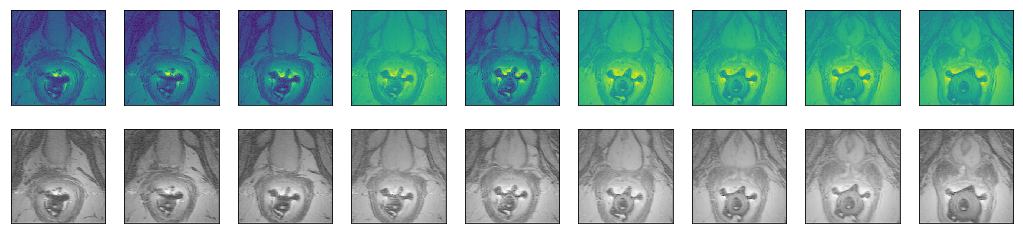

In [11]:
decoded_imgs = AEP.predict(train_data[0:10],batch_size=10)

n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(1,n):
    # display original
    ax = plt.subplot(2,n,i)
    plt.imshow((train_data[0:10][i][:,:,0]))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n ,i + n)
    plt.imshow((decoded_imgs[i][:,:,0]),cmap='gray')
    #plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [12]:
conv_3_model = Model(inputs=input_img, outputs=conv_3)
conv_3_images = conv_3_model.predict(vae_train_data,batch_size=10)

In [13]:
img_rows, img_cols = 256, 256
img_channels = 1

batch_size =50
latent_dim = 256
nb_epoch = 50
intermediate_dim =256
original_dim = img_rows*img_cols
LRelu = 'relu'

#USE = 'autoencoder'
#USE = 'vae'
#encoder:
input_img = Input(shape=(img_rows, img_cols,img_channels))
conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(input_img)
conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
drop4 = Dropout(0.5)(conv4)
pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
drop5 = Dropout(0.5)(conv5)

up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
merge6 = Concatenate()([drop4,up6])
conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
merge7 = Concatenate()([conv3,up7])
conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
merge8 =Concatenate()([conv2,up8])
conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
merge9 = Concatenate()([conv1,up9])
conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
conv10 = Conv2D(2, 1, activation = 'softmax')(conv9)

unet = Model(input = input_img, output = conv10)





#decoded = Conv2D(2, (3, 3), activation='softmax', padding='same')(upsample_10)
#decoded = Flatten()(decoded)
#decoded = Dense(256*256,activation='softmax')(decoded)


EarlyStopping = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=7, verbose=0, mode='auto')
checkpoint = ModelCheckpoint('model_keras_unet.h5',monitor ='val_loss',verbose = 1,save_best_only = True)

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true[:,:,:,1]) 
    y_pred_f = K.flatten(y_pred[:,:,:,1]) 
    intersection = K.sum(y_true_f * y_pred_f) 
    return (2. * intersection + 1e-6) / (K.sum(K.square(y_true_f)) + K.sum(K.square(y_pred_f)) + 1e-6)
def dice_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

#def ae_loss(x, decoded):  
#    xent_loss = original_dim * objectives.mean_squared_error(x,decoded)
#    return xent_loss
adam = keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
#autoencoder = Model(inputs=input_img, outputs=decoded)
unet.compile(optimizer=adam, loss=dice_loss)

/home/hao/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:55: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`


In [ ]:
#CheckPoint = keras.callbacks.ModelCheckpoint("Model_keras.h5", monitor='val_loss', verbose=0, save_best_only=False, save_weights_only=False, mode='auto', period=1)
unet.fit(conv_3_images[:1257], train_label,
        shuffle=True,
        epochs=50,
        batch_size=4,
        validation_data=(conv_3_images[1257:],test_label),callbacks=[EarlyStopping,checkpoint])

Train on 1257 samples, validate on 120 samples
Epoch 1/50
1257/1257 [==============================] - 237s 188ms/step - loss: -0.1811 - val_loss: -0.0596

Epoch 00001: val_loss improved from inf to -0.05962, saving model to model_keras_unet.h5
Epoch 2/50
1257/1257 [==============================] - 228s 181ms/step - loss: -0.1838 - val_loss: -0.0610

Epoch 00002: val_loss improved from -0.05962 to -0.06098, saving model to model_keras_unet.h5
Epoch 3/50
1257/1257 [==============================] - 228s 181ms/step - loss: -0.1857 - val_loss: -0.0623

Epoch 00003: val_loss improved from -0.06098 to -0.06233, saving model to model_keras_unet.h5
Epoch 4/50
1257/1257 [==============================] - 228s 181ms/step - loss: -0.1883 - val_loss: -0.0637

Epoch 00004: val_loss improved from -0.06233 to -0.06372, saving model to model_keras_unet.h5
Epoch 5/50
1257/1257 [==============================] - 228s 181ms/step - loss: -0.1923 - val_loss: -0.0652

Epoch 00005: val_loss improved from -